# Regressão - Previsão do valor de um ativo no dia seguinte

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares


# 1.    Data set - Seleção

Usamos a biblioteca **yfinance** para baixar dados históricos de ações da Apple (AAPL) dos últimos 10 anos. O dataset contém dados diários de preços (abertura, máxima, mínima, fechamento) e volume negociado.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter
from tensorflow.keras import layers, callbacks
from scipy.stats import normaltest
from tensorflow import keras
from mlp import mlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import tensorflow as tf


# baixar dados da Apple dos últimos 10 anos
df = yf.download("AAPL", period="10y", interval="1d", auto_adjust=True)
print("Shape:", df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

Shape: (2515, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-10-28,26.803,26.810,26.082,26.277,342205600
2015-10-29,27.086,27.122,26.578,26.675,204909200
2015-10-30,26.855,27.241,26.843,27.190,197461200
2015-11-02,27.232,27.273,26.879,27.147,128813200
2015-11-03,27.545,27.751,27.124,27.145,182076000


In [29]:
# remover nível de ticker se presente (robusto)
if isinstance(df.columns, pd.MultiIndex):
    for lvl in range(df.columns.nlevels):
        # se a camada for constante (ex.: todos 'AAPL'), removemos essa camada
        if df.columns.get_level_values(lvl).nunique() == 1:
            df.columns = df.columns.droplevel(lvl)
            break
print("Columns after flattening:", df.columns.tolist())


Columns after flattening: ['Close', 'High', 'Low', 'Open', 'Volume']


# 2. Data set - Explicação

O `DataFrame` `df` reúne cotações diárias da Apple (ticker `AAPL`) obtidas via `yfinance` para os últimos 10 anos (`period="10y"`, `interval="1d"`). A coluna de índice (`Date`) marca cada pregão. A partir das séries básicas (`Open`, `High`, `Low`, `Close`, `Volume`) derivaram‑se as features abaixo:

- `Price_Range`: `High - Low`. Medida de volatilidade intraday.  
- `Price_Change`: `Close - Open`. Variação diária absoluta (momentum do dia).  
- `High_Low_Ratio`: `High / Low`. Proporção de amplitude do dia (volatilidade relativa).  
- `Return_1d`, `Return_3d`, `Return_5d`, `Return_10d`: retornos percentuais em janelas 1/3/5/10 dias. Capturam momentum em diferentes horizontes.  
- `MA_5`, `MA_10`, `MA_20`, `MA_50`: médias móveis do preço de fechamento (suavização de tendência).  
- `Volatility_5`, `Volatility_10`, `Volatility_20`: desvio padrão móvel do fechamento (risco/instabilidade em janelas distintas).  
- `Volume_MA_5`, `Volume_MA_10`: médias móveis do volume (interesse de mercado suavizado).  
- `BB_Middle`, `BB_Upper`, `BB_Lower`, `BB_Width`: bandas de Bollinger (MA_20 ± 2·Volatility_20) e largura (volatilidade implícita).  
- `RSI`: índice de força relativa (14 dias), indicador de sobrecompra/sobrevenda.  
- `MACD`, `MACD_Signal`, `MACD_Histogram`: MACD (EMA12−EMA26), sua linha de sinal (EMA9) e histograma (força do momentum).  
- `Momentum_5`, `Momentum_10`: diferença absoluta do fechamento em 5 e 10 dias (velocidade da variação).  
- `ROC_5`, `ROC_10`: rate of change (%) em 5 e 10 dias (retorno percentual em diferentes janelas).  
- `Target`: `Close.shift(-1)` — preço de fechamento do próximo dia (variável alvo).

Essas features procuram capturar preço, volume, volatilidade e momentum em múltiplas escalas temporais. O objetivo é treinar uma rede neural capaz de estimar o preço de fechamento (`Close`) do dia seguinte a partir desse histórico.

Ainda, vale notar que todos os dados (features + target) são numéricos continuos

## Criação de novas features

In [30]:
print("\n CRIANDO FEATURES AVANÇADAS...")

# Features baseadas em preço
df['Price_Range'] = df['High'] - df['Low']  # Volatilidade intraday
df['Price_Change'] = df['Close'] - df['Open']  # Mudança diária
df['High_Low_Ratio'] = df['High'] / df['Low']  # Razão high/low

# Retornos percentuais
df['Return_1d'] = df['Close'].pct_change(1)  # Retorno de 1 dia
df['Return_3d'] = df['Close'].pct_change(3)  # Retorno de 3 dias
df['Return_5d'] = df['Close'].pct_change(5)  # Retorno de 5 dias
df['Return_10d'] = df['Close'].pct_change(10)  # Retorno de 10 dias

# Médias móveis
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Desvio padrão móvel (volatilidade)
df['Volatility_5'] = df['Close'].rolling(window=5).std()
df['Volatility_10'] = df['Close'].rolling(window=10).std()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

# Média móvel do volume
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()

# Bandas de Bollinger (simplificadas)
df['BB_Middle'] = df['MA_20']
df['BB_Upper'] = df['MA_20'] + 2 * df['Volatility_20']
df['BB_Lower'] = df['MA_20'] - 2 * df['Volatility_20']
df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']

# RSI simplificado (Relative Strength Index)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

# Features de momentum
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# Rate of Change (ROC)
df['ROC_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)) * 100
df['ROC_10'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

# Target: Preço de fechamento do próximo dia
df['Target'] = df['Close'].shift(-1)

print(f"Shape final após feature engineering: {df.shape}")
print(f"Total de features criadas: {df.shape[1] - 3}")  # -3 para Date, Close original e Target


 CRIANDO FEATURES AVANÇADAS...
Shape final após feature engineering: (2515, 34)
Total de features criadas: 31


## Crescimento da ação ao longo do tempo

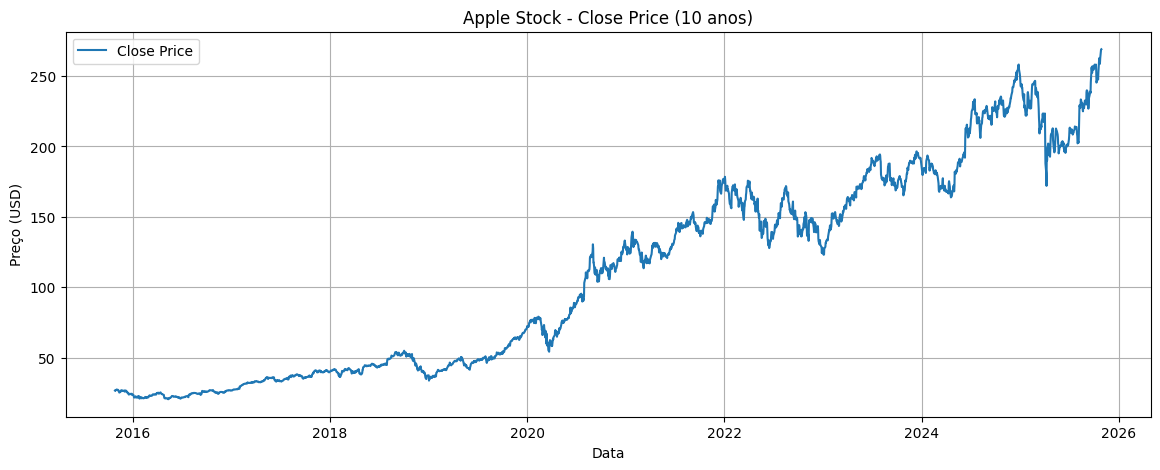

In [31]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

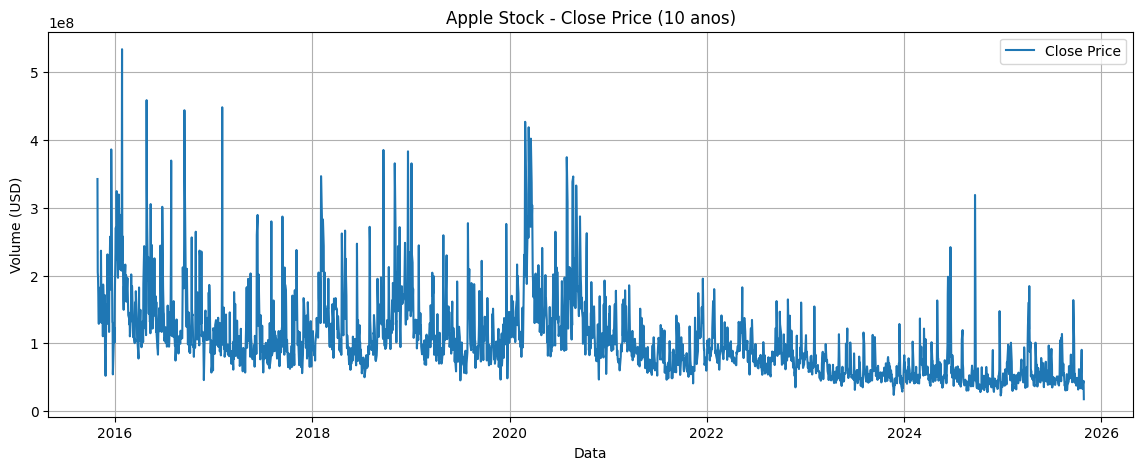

In [32]:
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Volume'], label='Close Price')
plt.title('Apple Stock - Close Price (10 anos)')
plt.xlabel('Data')
plt.ylabel('Volume (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Colunas com valores faltando

In [33]:
print("Valores faltantes por coluna:\n", df.isnull().sum())
df = df.dropna()

Valores faltantes por coluna:
 Price
Close              0
High               0
Low                0
Open               0
Volume             0
Price_Range        0
Price_Change       0
High_Low_Ratio     0
Return_1d          1
Return_3d          3
Return_5d          5
Return_10d        10
MA_5               4
MA_10              9
MA_20             19
MA_50             49
Volatility_5       4
Volatility_10      9
Volatility_20     19
Volume_MA_5        4
Volume_MA_10       9
BB_Middle         19
BB_Upper          19
BB_Lower          19
BB_Width          19
RSI               13
MACD               0
MACD_Signal        0
MACD_Histogram     0
Momentum_5         5
Momentum_10       10
ROC_5              5
ROC_10            10
Target             1
dtype: int64


In [34]:
print("Valores faltantes por coluna:\n", df.isnull().sum())

Valores faltantes por coluna:
 Price
Close             0
High              0
Low               0
Open              0
Volume            0
Price_Range       0
Price_Change      0
High_Low_Ratio    0
Return_1d         0
Return_3d         0
Return_5d         0
Return_10d        0
MA_5              0
MA_10             0
MA_20             0
MA_50             0
Volatility_5      0
Volatility_10     0
Volatility_20     0
Volume_MA_5       0
Volume_MA_10      0
BB_Middle         0
BB_Upper          0
BB_Lower          0
BB_Width          0
RSI               0
MACD              0
MACD_Signal       0
MACD_Histogram    0
Momentum_5        0
Momentum_10       0
ROC_5             0
ROC_10            0
Target            0
dtype: int64


### Foi utilizado um dropna, pois em algumas features, por exemplo, Momentum5 as 4 primeiras linhas não tem significado, já que é impossível calcular o valor

ARRUMAR TEXTO DEPOIS

## Visualizando as features

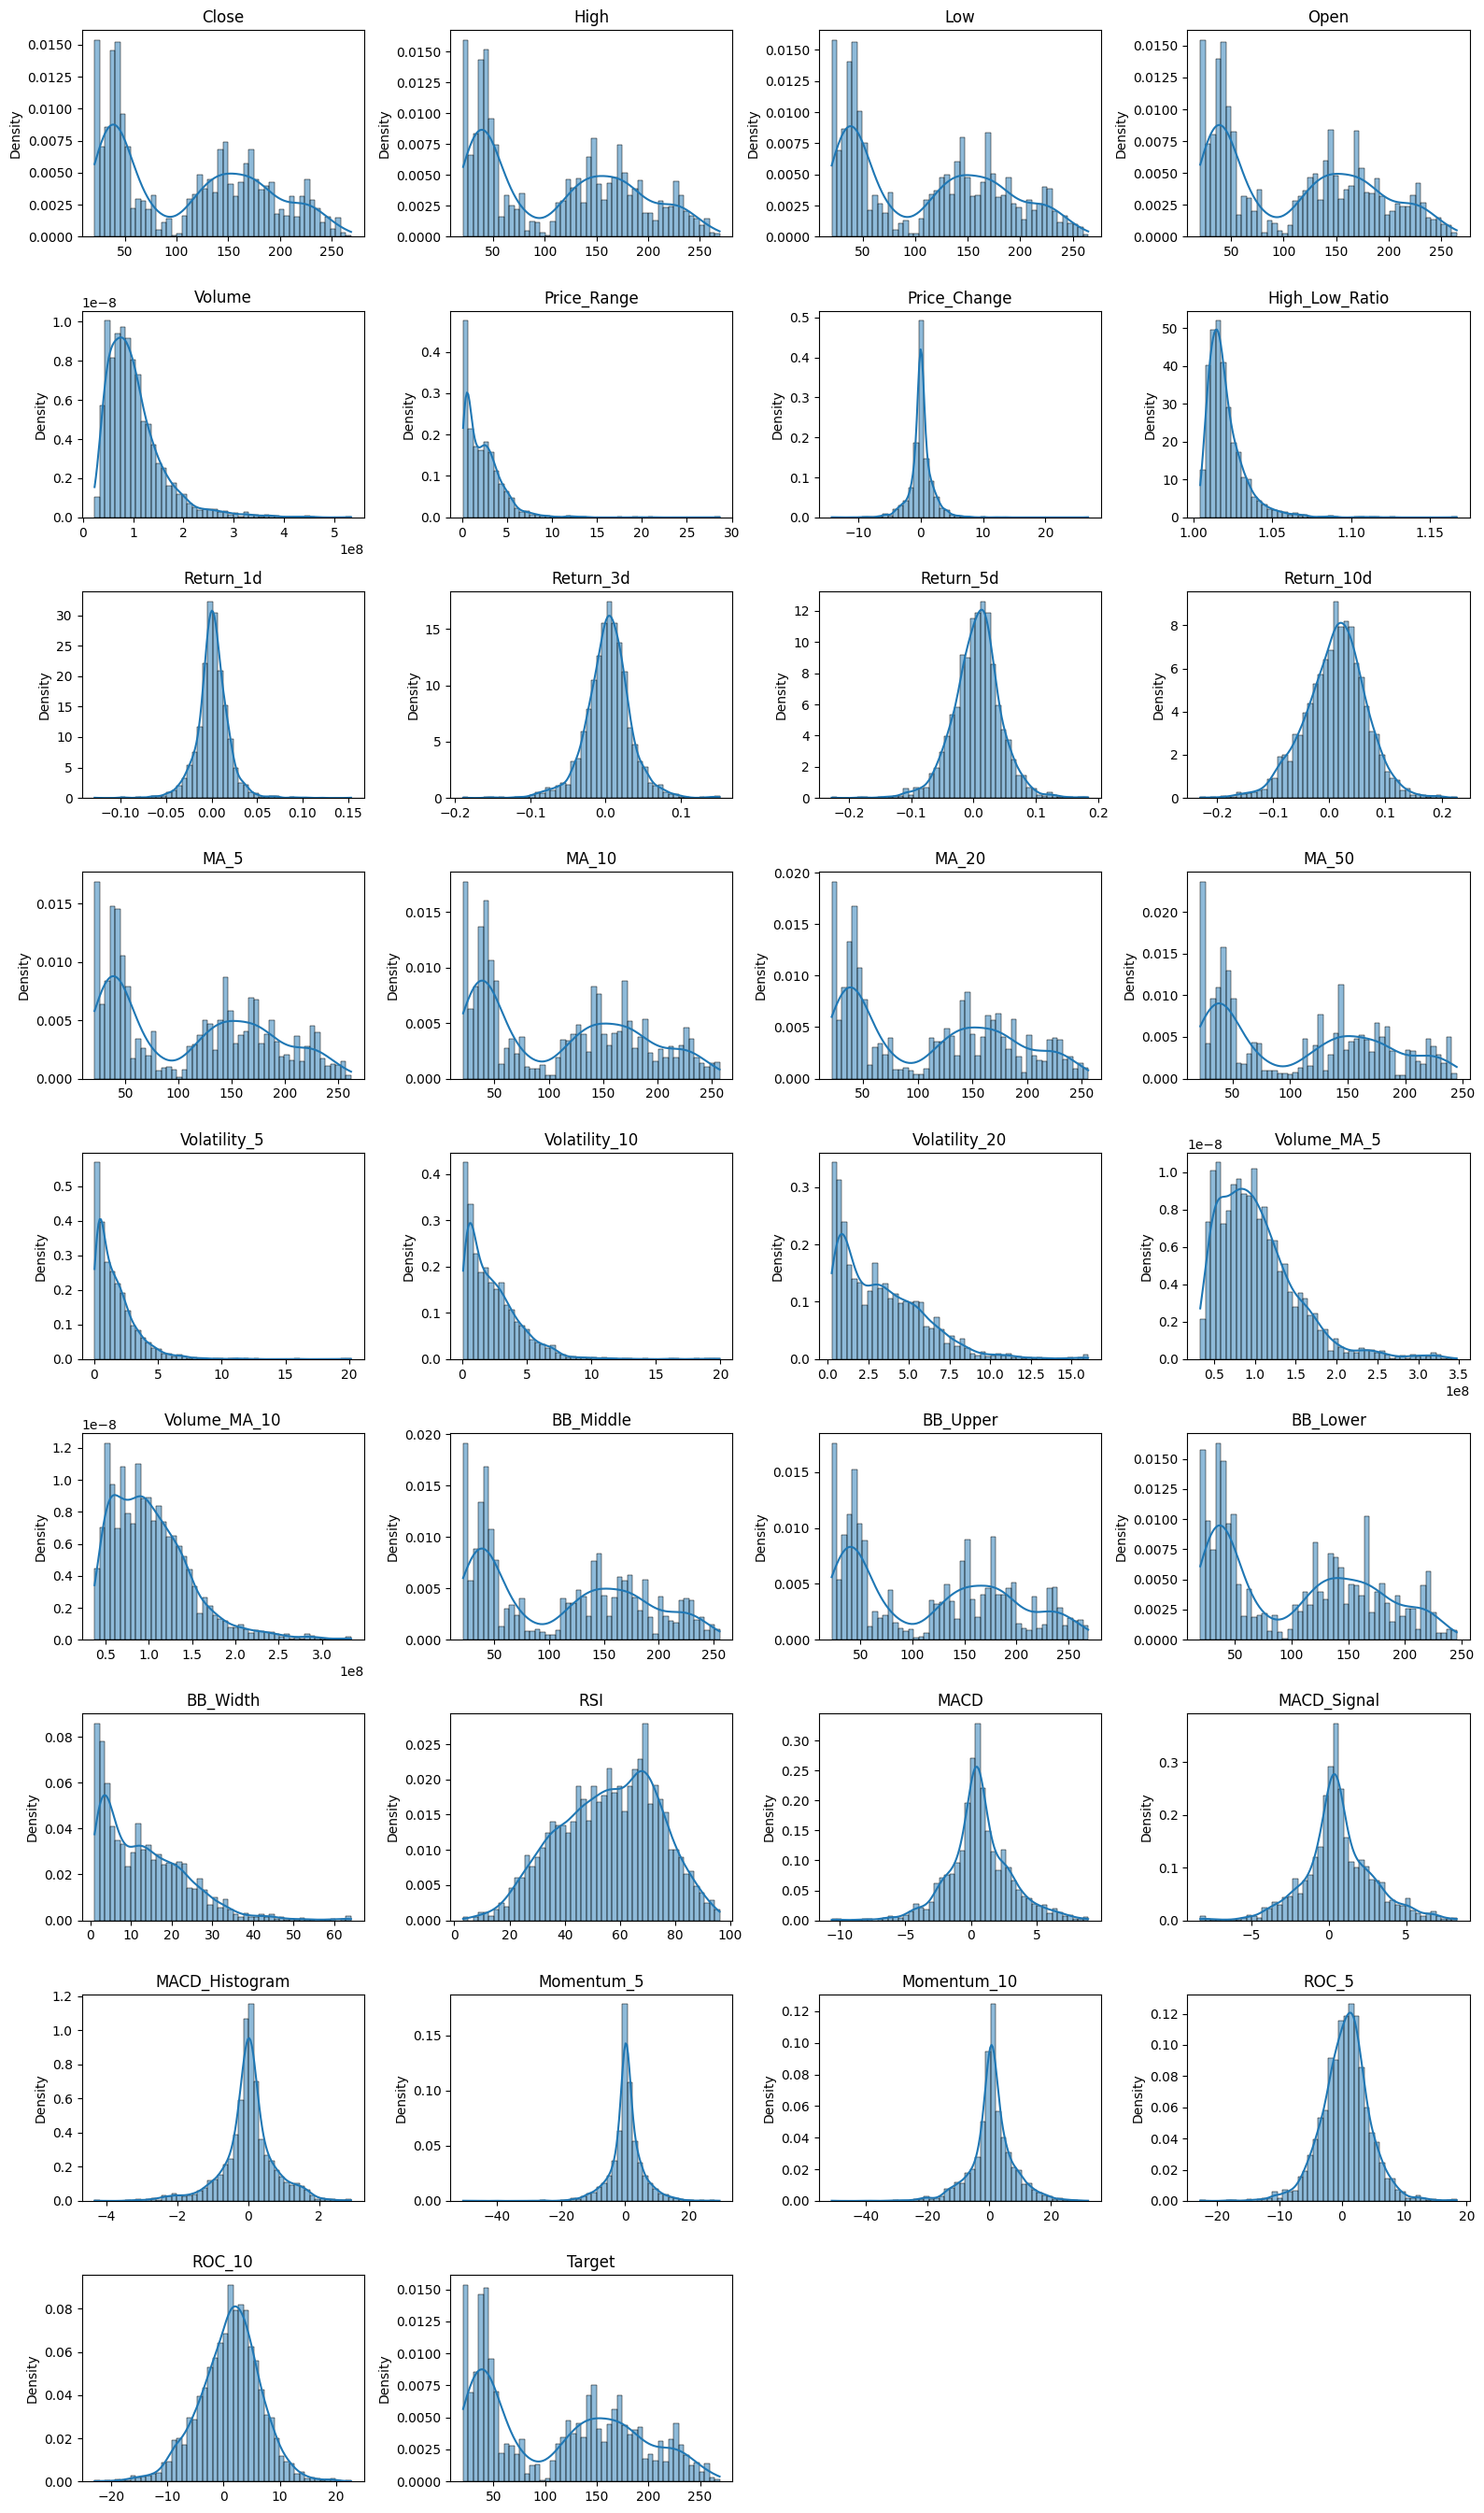

In [35]:
# Configura grid de subplots
n_cols = 4
n_features = len(df.columns)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    # remove NaNs antes de plotar
    data = df[col].dropna()
    if data.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(col)
        ax.set_axis_off()
        continue
    sns.histplot(data, bins=50, kde=True, ax=ax, stat='density', color='tab:blue')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Desativa eixos extras se houver
for j in range(n_features, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

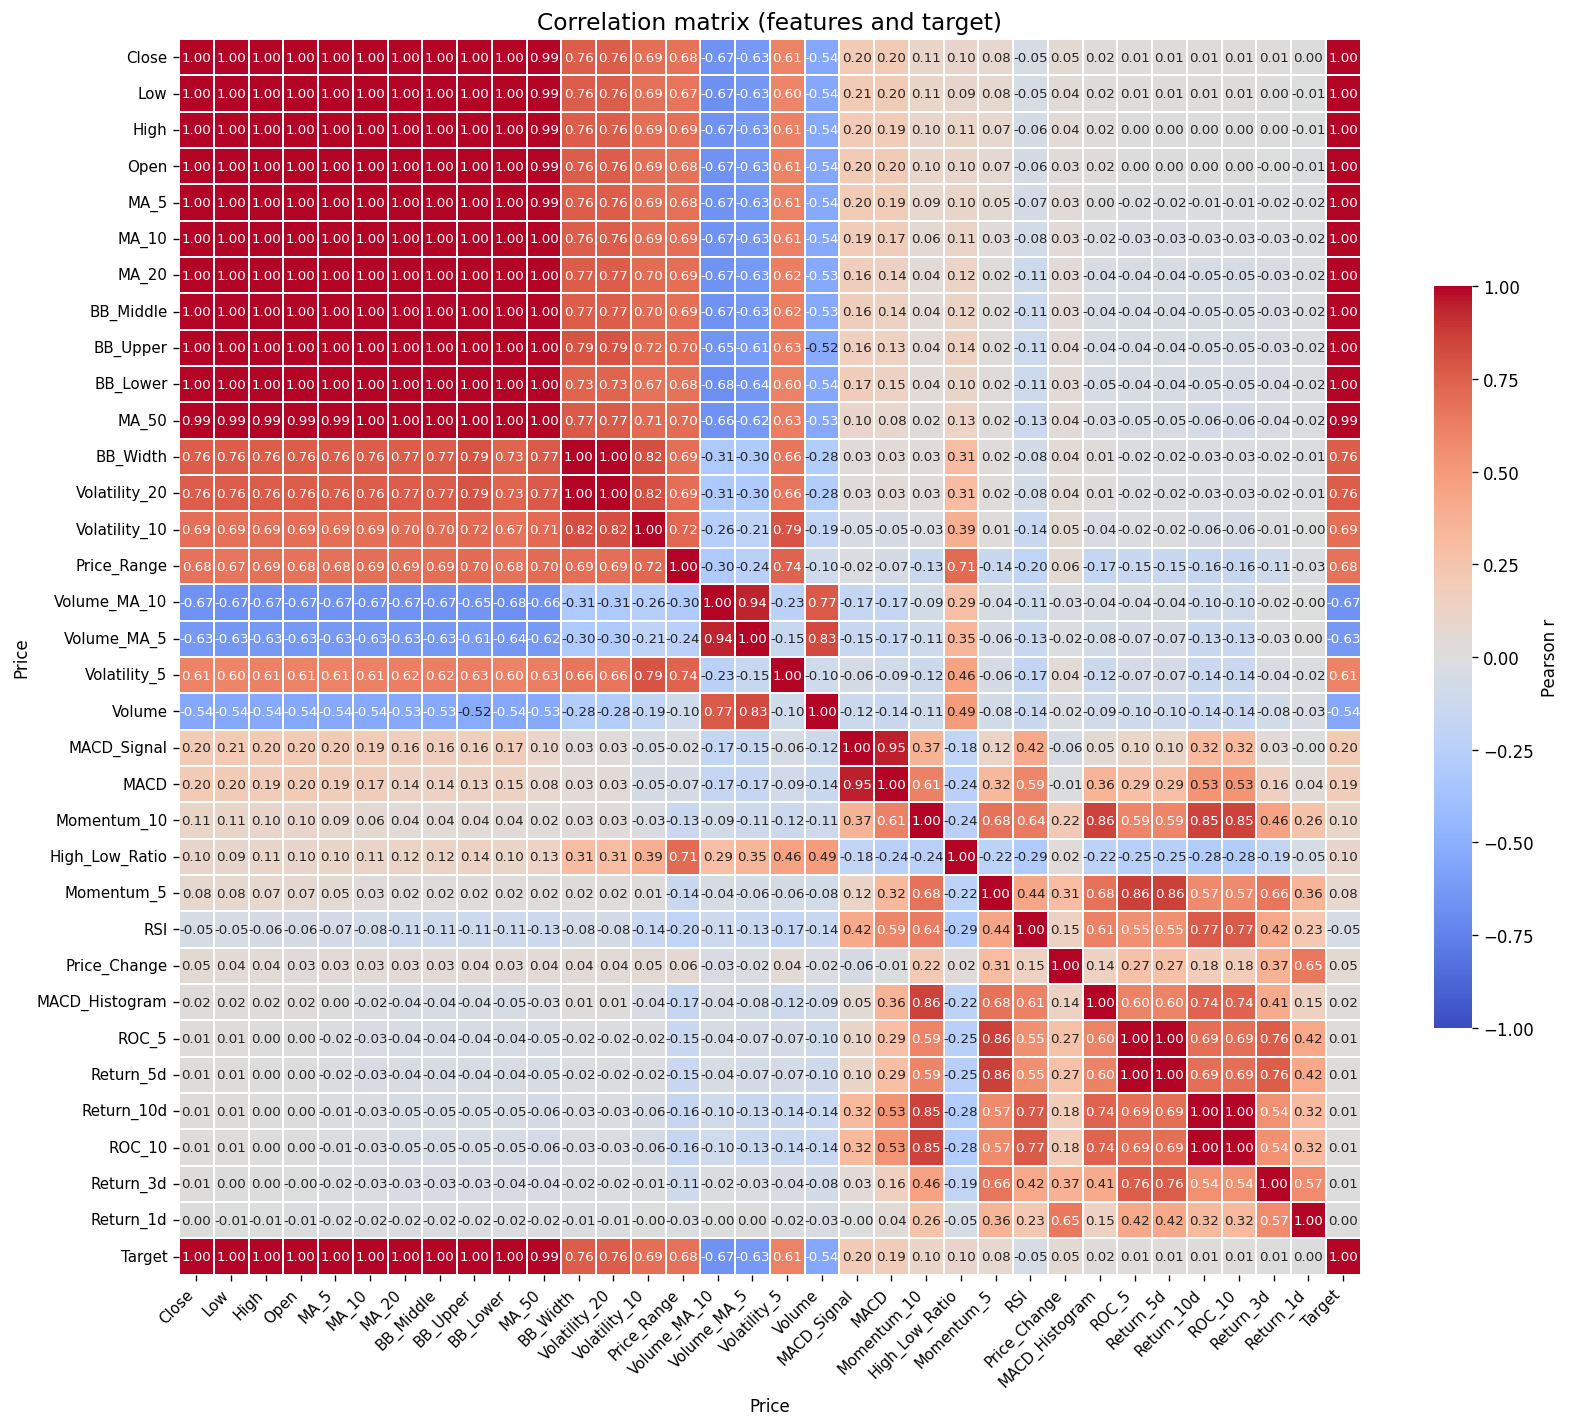


Top features por correlação (com sinal) com Target:


,corr_with_target
Price,
Close,0.999
Low,0.999
High,0.999
Open,0.999
MA_5,0.999
MA_10,0.998
MA_20,0.997
BB_Middle,0.997
BB_Upper,0.996



Média e desvio padrão das variáveis numéricas:


,mean,std
Price,,
Close,111.6373,70.7890
High,112.7478,71.4683
Low,110.4052,70.0177
Open,111.5266,70.7102
Volume,102524735.7404,57558176.6359
Price_Range,2.3426,2.1410
Price_Change,0.1107,1.9316
High_Low_Ratio,1.0205,0.0126
Return_1d,0.0012,0.0184


In [36]:
pd.options.display.float_format = '{:.3f}'.format

corr_df = df.corr()

order = corr_df['Target'].abs().sort_values(ascending=False).index.tolist()
# opcional: colocar o target no final para melhor leitura
order = [c for c in order if c != 'Target'] + ['Target']
corr_df = corr_df.loc[order, order]

# Plot heatmap com layout melhorado
plt.figure(figsize=(14, 12), dpi=120)
sns.heatmap(
    corr_df,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={'size':8},
    linewidths=0.25,
    cbar_kws={'shrink':0.6, 'label':'Pearson r'}
)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Correlation matrix (features and target)', fontsize=14)
plt.tight_layout()
plt.show()

top = corr_df['Target'].drop(index='Target').sort_values(key=lambda s: s.abs(), ascending=False)
print('\nTop features por correlação (com sinal) com Target:')
display(top.to_frame(name='corr_with_target'))

# Estatísticas descritivas: média e desvio padrão
stats = df.agg(['mean', 'std']).T
stats = stats.rename(columns={'mean':'mean','std':'std'})
print('\nMédia e desvio padrão das variáveis numéricas:')
display(stats.style.format('{:.4f}'))

# 3. Limpeza & Normalização

### Abordagem: realizar um teste de hipótese e verificar normalidade de função, caso ela seja, utilizamos normalização z-score, caso não é min-max.

### Teste de D'agostin e Pearson -> p-valor baixo: não normal (min-max) / p-valor alto: possivelmente normal, plotar histograma e vizualizar o caso

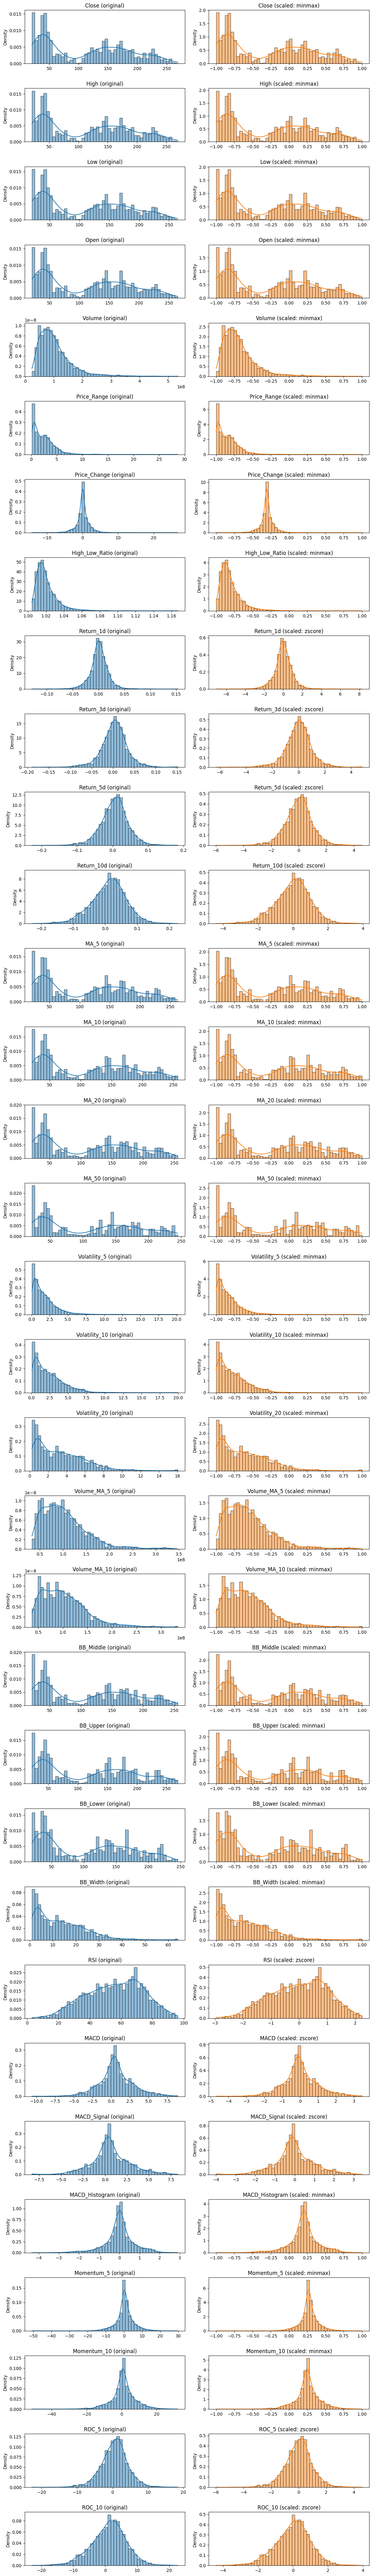

In [37]:
alpha = 0.02

df_orig = df.copy()

# decidir tipo de scaler usando uma amostra do dataset inteiro
sample = df.sample(n=min(1000, len(df)), random_state=42)

applied = {}

for col in df.columns:
    if col != 'Target':
        vals_sample = sample[col].values.reshape(-1, 1).astype(float)

        stat, p = normaltest(vals_sample[:100].ravel())

        if p >= alpha:
            scaler = StandardScaler()
            choice = "zscore"
        else:
            scaler = MinMaxScaler(feature_range=(-1,1))
            choice = "minmax"

        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).ravel()

        applied[col] = choice

cols = list(df.columns)
n_features = len(cols)-1


fig, axes = plt.subplots(n_features, 2, figsize=(12, 2.5 * n_features))
axes = np.atleast_2d(axes)

for i, c in enumerate(cols):
    if c != "Target":
        ax_orig = axes[i, 0]
        ax_scaled = axes[i, 1]

        data_orig = df_orig[c]
        data_scaled = df[c]

        # plot original
        sns.histplot(data_orig, bins=50, kde=True, ax=ax_orig, stat="density", color="tab:blue")
        ax_orig.set_title(f"{c} (original)")
        ax_orig.set_xlabel("")
        ax_orig.set_ylabel("Density")

        # plot scaled
        sns.histplot(data_scaled, bins=50, kde=True, ax=ax_scaled, stat="density", color="tab:orange")
        choice_label = applied.get(c, "?")
        ax_scaled.set_title(f"{c} (scaled: {choice_label})")
        ax_scaled.set_xlabel("")
        ax_scaled.set_ylabel("Density")

plt.tight_layout()
plt.show()


# 4. Implementação MLP

### Só falar do mlp.py

# 5. Treinando o modelo

In [38]:
n = len(df)
split_at = int(n * 0.7)
train = df.iloc[:split_at].copy()
test = df.iloc[split_at:].copy()

print(f"Full shape: {df.shape}")
print(f"Train rows: {len(train)}, Test rows: {len(test)}")

Full shape: (2465, 34)
Train rows: 1725, Test rows: 740


## Data Windowing para Séries Temporais

Para respeitar a estrutura temporal dos dados, implementamos **janelas deslizantes**:
- `input_width`: número de dias históricos usados como entrada (ex.: 6).
- `offset`: quantos dias à frente queremos prever (ex.: 1 dia à frente).
- `label_width`: quantos dias futuros prever (ex.: 1).

Cada amostra passa de um vetor (1 dia) para uma **sequência** (6 dias → 1 predição).

In [39]:
def create_windowed_dataset(data, features_cols, target_col, input_width=6, offset=1):
    """
    Cria janelas deslizantes para séries temporais.
    
    Args:
        data: DataFrame já ordenado cronologicamente
        features_cols: lista com nomes das colunas de entrada
        target_col: nome da coluna alvo
        input_width: quantos passos históricos usar
        offset: quantos passos à frente prever (1 = próximo dia)
    
    Returns:
        X: (n_samples, input_width, n_features)
        y: (n_samples,)
    """
    X, y = [], []
    values = data[features_cols].values
    targets = data[target_col].values
    
    for i in range(len(data) - input_width - offset + 1):
        X.append(values[i:i+input_width])
        y.append(targets[i+input_width+offset-1])
    
    return np.array(X), np.array(y)

# Parâmetros da janela
INPUT_WIDTH = 30   # usar 30 dias históricos
OFFSET = 1        # prever 1 dia à frente

features = [c for c in train.columns if c != "Target"]

# Criar janelas para treino e teste
X_train, y_train = create_windowed_dataset(train, features, "Target", INPUT_WIDTH, OFFSET)
X_test, y_test = create_windowed_dataset(test, features, "Target", INPUT_WIDTH, OFFSET)

print(f"X_train shape: {X_train.shape} -> (n_samples, input_width={INPUT_WIDTH}, n_features={len(features)})")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1695, 30, 33) -> (n_samples, input_width=30, n_features=33)
y_train shape: (1695,)
X_test shape: (710, 30, 33)
y_test shape: (710,)


### Exemplo visual da janela

Para `INPUT_WIDTH=6` e `OFFSET=1`:
```
Dias:    t=0  t=1  t=2  t=3  t=4  t=5  | t=6 (alvo)
         [─────────── entrada ──────────]   ↑
                                           predição
```

Cada linha do treino vira uma **sequência de 6 dias** que prevê o dia 7.

## Comparação concreta: com vs sem janelas

**Abordagem ANTIGA (sem janelas):**
- Cada amostra = **33 números** (features de 1 único dia)
- Total de amostras = quase todos os dias (~2500 amostras)

**Abordagem NOVA (com janelas de 6 dias):**
- Cada amostra = **198 números** (33 features × 6 dias = 198)
- Total de amostras = reduz um pouco (~2494 amostras, perde 6 no início)

**A diferença NÃO é na estrutura (ambos são vetores), mas no CONTEÚDO:**

In [40]:
print("=" * 70)
print("COMPARAÇÃO: ABORDAGEM ANTIGA vs NOVA")
print("=" * 70)

# Simular abordagem ANTIGA (sem janelas)
X_old = train[features].values[:10]  # 10 primeiras amostras
print("\n🔴 ABORDAGEM ANTIGA (sem janelas):")
print(f"   Shape: {X_old.shape} -> (10 amostras, 33 features)")
print(f"   Cada linha = 1 dia completo")
print(f"\n   Amostra 0 (dia 0): {X_old[0][:5]}... (mostrando primeiras 5 features)")
print(f"   Amostra 1 (dia 1): {X_old[1][:5]}...")
print(f"   Amostra 2 (dia 2): {X_old[2][:5]}...")

# Abordagem NOVA (com janelas)
X_new_windowed, _ = create_windowed_dataset(train.head(16), features, "Target", INPUT_WIDTH, OFFSET)
X_new = X_new_windowed[:10].reshape(10, -1)  # achatar para comparar
print("\n\n🟢 ABORDAGEM NOVA (com janelas de 30 dias):")
print(f"   Shape: {X_new.shape} -> (10 amostras, 198 features)")
print(f"   Cada linha = 30 dias concatenados (30×33 = 990)")
print(f"\n   Amostra 0 (dias 0→29): {X_new[0][:5]}... (primeiras 5 de 990)")
print(f"   Amostra 1 (dias 1→30): {X_new[1][:5]}...")
print(f"   Amostra 2 (dias 2→31): {X_new[2][:5]}...")

print("\n" + "=" * 70)
print("INTERPRETAÇÃO:")
print("=" * 70)
print("🔴 Antiga: modelo vê 'Open_dia0, High_dia0, ..., ROC10_dia0' (33 valores)")
print("   → tenta prever dia 1 SEM contexto histórico")
print()
print("🟢 Nova: modelo vê 'Open_dia0, High_dia0, ..., ROC10_dia29' (198 valores)")
print("   → tem TODO o histórico de 30 dias para prever dia 31")
print("=" * 70)

COMPARAÇÃO: ABORDAGEM ANTIGA vs NOVA

🔴 ABORDAGEM ANTIGA (sem janelas):
   Shape: (10, 33) -> (10 amostras, 33 features)
   Cada linha = 1 dia completo

   Amostra 0 (dia 0): [-0.98985759 -0.9883944  -0.98843622 -0.98612491  0.01895269]... (mostrando primeiras 5 features)
   Amostra 1 (dia 1): [-0.98700224 -0.98848535 -0.98736428 -0.98534902 -0.31122026]...
   Amostra 2 (dia 2): [-0.98440151 -0.98552094 -0.98459199 -0.98243017 -0.32039547]...


🟢 ABORDAGEM NOVA (com janelas de 30 dias):
   Shape: (10, 0) -> (10 amostras, 198 features)
   Cada linha = 30 dias concatenados (30×33 = 990)

   Amostra 0 (dias 0→29): []... (primeiras 5 de 990)
   Amostra 1 (dias 1→30): []...
   Amostra 2 (dias 2→31): []...

INTERPRETAÇÃO:
🔴 Antiga: modelo vê 'Open_dia0, High_dia0, ..., ROC10_dia0' (33 valores)
   → tenta prever dia 1 SEM contexto histórico

🟢 Nova: modelo vê 'Open_dia0, High_dia0, ..., ROC10_dia29' (198 valores)
   → tem TODO o histórico de 30 dias para prever dia 31


In [41]:
# Como o MLP custom não aceita sequências 3D, achatamos as janelas
# X_train: (samples, 30 days, 33 features) -> (samples, 30*33=990)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

# model = mlp(
#     n_features=X_train_flat.shape[1],
#     n_hidden_layers=4,
#     n_neurons_per_layer=[1800, 128, 64, 32, 1],
#     activation="relu",
#     loss="mse",
#     optimizer="gd",
#     epochs=300,
#     eta=5e-4
# )

# model.train(X_train_flat, y_train)

X_train_flat shape: (1695, 990)
X_test_flat shape: (710, 990)


In [42]:
# Modelo MLP com Keras (usando dados achatados)
model_mlp = keras.Sequential([
    layers.Input(shape=(X_train_flat.shape[1],)),  # 990 features (30*33)
    layers.Dense(1800, activation='relu'),
    layers.Dropout(0.2),  # regularização
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # saída: 1 valor (preço)
], name="MLP_Flattened")

model_mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse',
    metrics=['mae']
)

model_mlp.summary()

Model: "MLP_Flattened"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1800)           │     1,783,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       230,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,024,697 (7.72 MB)

 Trainable params: 2,024,697 (7.72 MB)

 Non-trainable params: 0 (0.00 B)

### 🔧 Callbacks: Controles Inteligentes de Treinamento

**Callbacks** são funções que o TensorFlow executa automaticamente durante o treinamento para melhorar os resultados. Pense neles como "alarmes inteligentes" que monitoram o processo.

#### 1️⃣ **EarlyStopping** (Parada Antecipada)
```python
monitor='loss'        # Observa a loss de treino
patience=30           # Espera 30 épocas sem melhora
restore_best_weights  # Volta aos melhores pesos
```

**O que faz**: 
- Monitora a `loss` (erro) a cada época
- Se a loss **não melhorar** por 30 épocas consecutivas → **PARA O TREINO**
- Restaura os pesos da melhor época (evita overfitting)

**Exemplo prático**:
```
Época 50: loss = 100.5  ← melhor até agora
Época 51: loss = 101.2
...
Época 80: loss = 102.0  ← 30 épocas sem melhora, PARA!
Modelo final usa os pesos da época 50 ✅
```

**Benefício**: Economiza tempo (não treina 300 épocas se já convergiu em 80)

---

#### 2️⃣ **ReduceLROnPlateau** (Redução Automática do Learning Rate)
```python
monitor='loss'    # Observa a loss
factor=0.5        # Reduz LR pela metade
patience=10       # Espera 10 épocas sem melhora
min_lr=1e-6       # LR mínimo permitido
```

**O que faz**:
- Monitora a `loss` a cada época
- Se a loss **estagnar** por 10 épocas → **REDUZ o learning rate pela metade**
- Continua reduzindo até atingir o mínimo (`1e-6`)

**Exemplo prático**:
```
Época 1-30:  LR = 5e-4 (0.0005)  → loss cai de 500 → 100
Época 31-40: loss estagnada em ~100
Época 41:    LR = 2.5e-4 (0.00025)  ← REDUZIU!
Época 41-60: loss cai de 100 → 50  ← aprendizado mais refinado
Época 61-70: loss estagnada em ~50
Época 71:    LR = 1.25e-4  ← REDUZIU DE NOVO!
```

**Benefício**: 
- Learning rate alto no início → convergência rápida
- Learning rate baixo depois → ajustes finos (não ultrapassa o mínimo)

---

### 🎯 Analogia: Procurando o ponto mais baixo de um vale

**Sem callbacks**: Você caminha sempre com passos gigantes, pode pular o vale ou nunca chegar no fundo.

**Com ReduceLROnPlateau**: Começa com passos grandes, mas quando se aproxima do fundo, automaticamente **reduz o tamanho dos passos** para encontrar o ponto exato.

**Com EarlyStopping**: Quando você percebe que está andando em círculos (30 passos sem descer mais), **PARA** e fica no melhor ponto que encontrou.

---

### 📊 Visualização do efeito

Após o treino, você pode plotar:
```python
plt.plot(history_mlp.history['loss'])
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss durante treinamento (com callbacks)')
```

Você verá:
- **Platôs** (trechos planos) onde o LR foi reduzido
- **Parada** antes das 300 épocas (early stopping)
- Curva suave descendo até o mínimo

In [43]:
# Callbacks para melhorar o treinamento
early_stop = callbacks.EarlyStopping(
    monitor='loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

# Treinar
history_mlp = model_mlp.fit(
    X_train_flat, y_train,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2339.6001 - mae: 33.4192 - learning_rate: 5.0000e-04
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2339.6001 - mae: 33.4192 - learning_rate: 5.0000e-04
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 144.8116 - mae: 8.8323 - learning_rate: 5.0000e-04
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 144.8116 - mae: 8.8323 - learning_rate: 5.0000e-04
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 100.1809 - mae: 7.2608 - learning_rate: 5.0000e-04
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 100.1809 - mae: 7.2608 - learning_rate: 5.0000e-04
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 82.7672 - mae: 6.8056 - learning_rate: 5.0000e-04
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 82.7672 - mae: 6.8056 - learning_rate: 5.0000e-04
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 69.8101 - mae: 6.0871 - learning_rate: 5.0000e-04


In [ ]:
# Predições no conjunto de teste
preds_mlp_keras = model_mlp.predict(X_test_flat).flatten()

mae = mean_absolute_error(y_test, preds_mlp_keras)
rmse = np.sqrt(mean_squared_error(y_test, preds_mlp_keras))
r2 = r2_score(y_test, preds_mlp_keras)

print("\n" + "="*60)
print("RESULTADOS - MLP Keras (janelas achatadas)")
print("="*60)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")
print("="*60)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

RESULTADOS - MLP Keras (janelas achatadas)
MAE:  31.9542
RMSE: 32.7650
R²:   -0.1504

RESULTADOS - MLP Keras (janelas achatadas)
MAE:  31.9542
RMSE: 32.7650
R²:   -0.1504


### Curvas de treinamento: Loss e Métricas por Época

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Loss (MSE) por época
epochs_range = range(1, len(history_mlp.history['loss']) + 1)
ax1.plot(epochs_range, history_mlp.history['loss'], linewidth=2, color='steelblue', label='Loss (MSE)')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('MSE (Mean Squared Error)', fontsize=12)
ax1.set_title('Erro (MSE) durante o Treinamento', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Destacar onde houve redução de LR (aproximação visual dos platôs)
# Detectar platôs automaticamente
loss_diff = np.diff(history_mlp.history['loss'])
plateau_threshold = np.std(loss_diff) * 0.1
for i in range(1, len(loss_diff)):
    if abs(loss_diff[i]) < plateau_threshold:
        ax1.axvline(x=i+1, color='red', linestyle='--', alpha=0.2)

# Plot 2: MAE por época
ax2.plot(epochs_range, history_mlp.history['mae'], linewidth=2, color='forestgreen', label='MAE')
ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('MAE (Mean Absolute Error)', fontsize=12)
ax2.set_title('Métrica (MAE) durante o Treinamento', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Adicionar informação final
final_loss = history_mlp.history['loss'][-1]
final_mae = history_mlp.history['mae'][-1]
ax1.text(0.98, 0.95, f'Loss final: {final_loss:.4f}', 
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)
ax2.text(0.98, 0.95, f'MAE final: {final_mae:.4f}', 
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Resumo do Treinamento:")
print(f"   Total de épocas: {len(history_mlp.history['loss'])}")
print(f"   Loss inicial: {history_mlp.history['loss'][0]:.4f}")
print(f"   Loss final: {final_loss:.4f}")
print(f"   Redução: {(1 - final_loss/history_mlp.history['loss'][0])*100:.2f}%")

### Comparação: Predições vs Real vs Baseline


COMPARAÇÃO: MODELO vs BASELINE
Baseline (média): MAE = 121.7226, R² = -15.8775
MLP Keras:        MAE = 31.9542, R² = -0.1504

Melhora sobre baseline: 73.75% no MAE


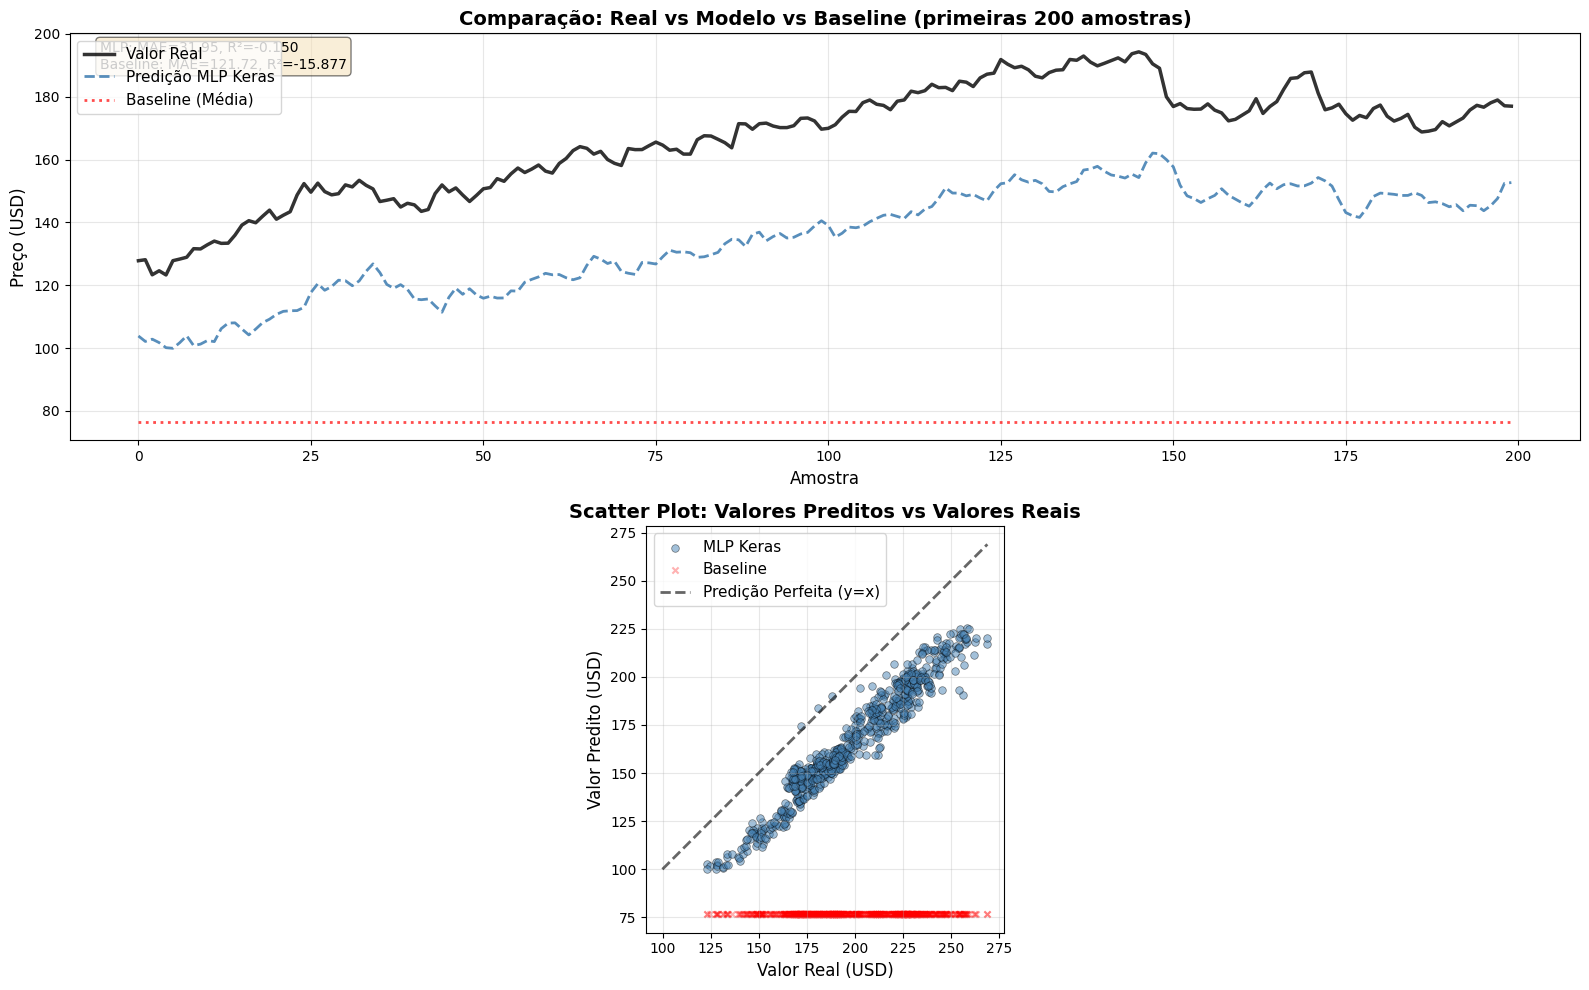

In [ ]:
# Criar baseline: média dos valores de treino (baseline mais simples)
baseline_mean = np.full_like(y_test, y_train.mean())

# Calcular métricas da baseline
mae_baseline = mean_absolute_error(y_test, baseline_mean)
r2_baseline = r2_score(y_test, baseline_mean)

print("\n" + "="*70)
print("COMPARAÇÃO: MODELO vs BASELINE")
print("="*70)
print(f"Baseline (média): MAE = {mae_baseline:.4f}, R² = {r2_baseline:.4f}")
print(f"MLP Keras:        MAE = {mae:.4f}, R² = {r2:.4f}")
print(f"\nMelhora sobre baseline: {((mae_baseline - mae)/mae_baseline * 100):.2f}% no MAE")
print("="*70)

# Plot comparativo: Real vs Predição vs Baseline
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Primeiras 200 amostras
n_samples = 200
axes[0].plot(y_test[:n_samples], label='Valor Real', color='black', linewidth=2.5, alpha=0.8)
axes[0].plot(preds_mlp_keras[:n_samples], label='Predição MLP Keras', 
            color='steelblue', linestyle='--', linewidth=2, alpha=0.9)
axes[0].plot(baseline_mean[:n_samples], label='Baseline (Média)', 
            color='red', linestyle=':', linewidth=2, alpha=0.7)
axes[0].set_title(f'Comparação: Real vs Modelo vs Baseline (primeiras {n_samples} amostras)', 
                fontsize=14, fontweight='bold')
axes[0].set_ylabel('Preço (USD)', fontsize=12)
axes[0].set_xlabel('Amostra', fontsize=12)
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3)

# Adicionar texto com métricas
textstr = f'MLP: MAE={mae:.2f}, R²={r2:.3f}\nBaseline: MAE={mae_baseline:.2f}, R²={r2_baseline:.3f}'
axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Subplot 2: Scatter plot - Predito vs Real
axes[1].scatter(y_test, preds_mlp_keras, alpha=0.5, s=30, 
                color='steelblue', label='MLP Keras', edgecolors='black', linewidth=0.5)
axes[1].scatter(y_test, baseline_mean, alpha=0.3, s=20, 
                color='red', label='Baseline', marker='x')

# Linha diagonal perfeita (y=x)
min_val = min(y_test.min(), preds_mlp_keras.min())
max_val = max(y_test.max(), preds_mlp_keras.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 
             'k--', linewidth=2, label='Predição Perfeita (y=x)', alpha=0.6)

axes[1].set_xlabel('Valor Real (USD)', fontsize=12)
axes[1].set_ylabel('Valor Predito (USD)', fontsize=12)
axes[1].set_title('Scatter Plot: Valores Preditos vs Valores Reais', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11, loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### Análise de Resíduos (Erros de Predição)

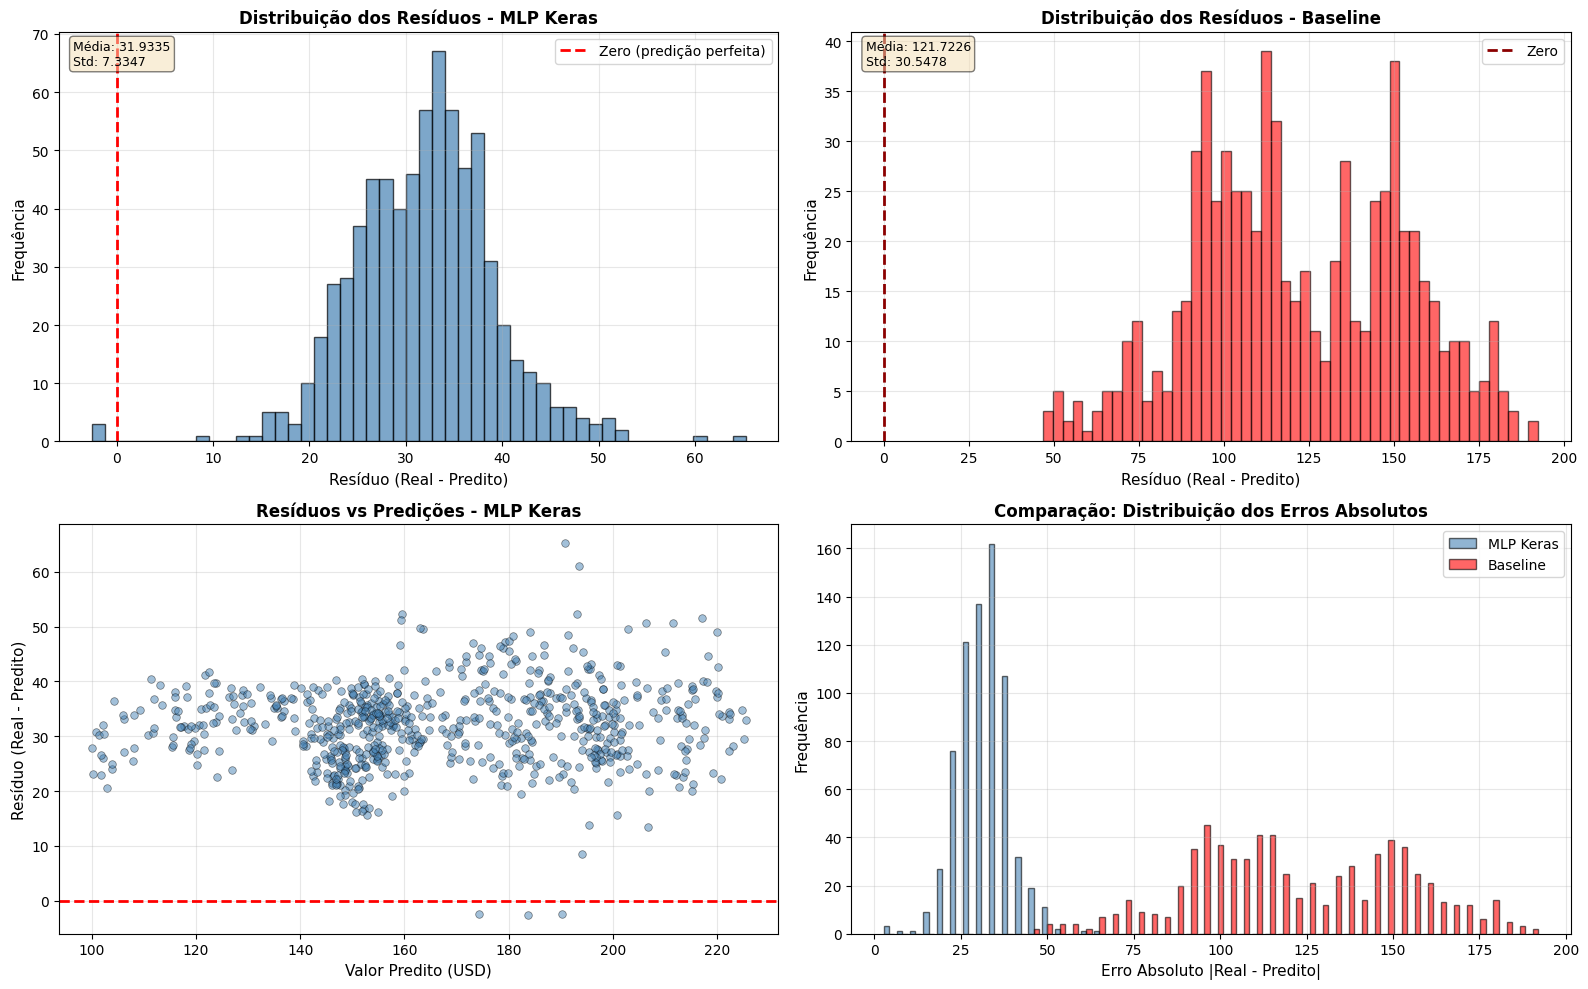


ANÁLISE DE RESÍDUOS

MLP Keras:
  Média dos resíduos: 31.9335 (ideal: ~0)
  Desvio padrão:      7.3347
  Erro máximo:        65.2791

Baseline:
  Média dos resíduos: 121.7226
  Desvio padrão:      30.5478
  Erro máximo:        192.3768


In [54]:
# Calcular resíduos (erros)
residuals_mlp = y_test - preds_mlp_keras
residuals_baseline = y_test - baseline_mean

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Distribuição dos resíduos (MLP)
axes[0, 0].hist(residuals_mlp, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (predição perfeita)')
axes[0, 0].set_xlabel('Resíduo (Real - Predito)', fontsize=11)
axes[0, 0].set_ylabel('Frequência', fontsize=11)
axes[0, 0].set_title('Distribuição dos Resíduos - MLP Keras', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'Média: {residuals_mlp.mean():.4f}\nStd: {residuals_mlp.std():.4f}', 
                transform=axes[0, 0].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# 2. Distribuição dos resíduos (Baseline)
axes[0, 1].hist(residuals_baseline, bins=50, color='red', alpha=0.6, edgecolor='black')
axes[0, 1].axvline(x=0, color='darkred', linestyle='--', linewidth=2, label='Zero')
axes[0, 1].set_xlabel('Resíduo (Real - Predito)', fontsize=11)
axes[0, 1].set_ylabel('Frequência', fontsize=11)
axes[0, 1].set_title('Distribuição dos Resíduos - Baseline', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.02, 0.98, f'Média: {residuals_baseline.mean():.4f}\nStd: {residuals_baseline.std():.4f}', 
                transform=axes[0, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

# 3. Resíduos vs Valores Preditos (MLP)
axes[1, 0].scatter(preds_mlp_keras, residuals_mlp, alpha=0.5, s=30, color='steelblue', edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Valor Predito (USD)', fontsize=11)
axes[1, 0].set_ylabel('Resíduo (Real - Predito)', fontsize=11)
axes[1, 0].set_title('Resíduos vs Predições - MLP Keras', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparação dos erros absolutos
errors_mlp = np.abs(residuals_mlp)
errors_baseline = np.abs(residuals_baseline)

axes[1, 1].hist([errors_mlp, errors_baseline], bins=50, 
                label=['MLP Keras', 'Baseline'], 
                color=['steelblue', 'red'], alpha=0.6, edgecolor='black')
axes[1, 1].set_xlabel('Erro Absoluto |Real - Predito|', fontsize=11)
axes[1, 1].set_ylabel('Frequência', fontsize=11)
axes[1, 1].set_title('Comparação: Distribuição dos Erros Absolutos', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas dos resíduos
print("\n" + "="*70)
print("ANÁLISE DE RESÍDUOS")
print("="*70)
print(f"\nMLP Keras:")
print(f"  Média dos resíduos: {residuals_mlp.mean():.4f} (ideal: ~0)")
print(f"  Desvio padrão:      {residuals_mlp.std():.4f}")
print(f"  Erro máximo:        {np.abs(residuals_mlp).max():.4f}")
print(f"\nBaseline:")
print(f"  Média dos resíduos: {residuals_baseline.mean():.4f}")
print(f"  Desvio padrão:      {residuals_baseline.std():.4f}")
print(f"  Erro máximo:        {np.abs(residuals_baseline).max():.4f}")
print("="*70)